In [138]:
### MVP
## start with node data frame
## create node depenency dataframe
## check if it is an accylic graph
## sort the nodes
## run the nodes
#@ capture errors and remove sub-tree where a node fails
## graph the nodes

### extras
# parralel running
# group trees
# show errors
# interactive

In [148]:
from datetime import datetime

# data wrangling
import numpy as np
import pandas as pd

# graph algorithms
import networkx as nx

# running scripts and catching errors
import subprocess

# visualisation
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pydot
from networkx.drawing.nx_pydot import graphviz_layout


# sample ETL process specs
schedule_data = {"process" : [
                "extract_2",
                "extract_3",
                "transform_1",
                "transform_2",
                "transform_3",
                "transform_4",
                "transform_5",
                "transform_6",
                "extract_1",
                "load_1",
                "load_2",
                "load_3",
                "load_4"
                ],
                "dep_on" : [
                np.nan,
                np.nan,
                "extract_1,extract_2",
                "extract_1",
                "transform_1,transform_4",
                "extract_3",
                "transform_4",
                "transform_2",
                np.nan,
                "transform_2",
                "transform_5,transform_6",
                "transform_3",
                "transform_4"
                ]
        }

schedule_df = pd.DataFrame(schedule_data)
schedule_df['location'] = "scripts/" + schedule_df['process'] + ".py"
schedule_df['status'] = "no status"
schedule_df['last_run'] = "never"

schedule_df

,process,dep_on,location,status,last_run
0,extract_2,NaN,scripts/extract_2.py,no status,never
1,extract_3,NaN,scripts/extract_3.py,no status,never
2,transform_1,"extract_1,extract_2",scripts/transform_1.py,no status,never
3,transform_2,extract_1,scripts/transform_2.py,no status,never
4,transform_3,"transform_1,transform_4",scripts/transform_3.py,no status,never
5,transform_4,extract_3,scripts/transform_4.py,no status,never
6,transform_5,transform_4,scripts/transform_5.py,no status,never
7,transform_6,transform_2,scripts/transform_6.py,no status,never
8,extract_1,NaN,scripts/extract_1.py,no status,never
9,load_1,transform_2,scripts/load_1.py,no status,never


In [149]:
# modify to create dependency dataframe fit for networkx

schedule_dep = schedule_df[['process', 'dep_on']]

# expand the dep_on row into mutiple rows based on ","
schedule_dep = schedule_dep.set_index(['process']).apply(lambda x: x.str.split(',').explode()).reset_index()
schedule_dep = schedule_dep.dropna()

schedule_dep

,process,dep_on
2,transform_1,extract_1
3,transform_1,extract_2
4,transform_2,extract_1
5,transform_3,transform_1
6,transform_3,transform_4
7,transform_4,extract_3
8,transform_5,transform_4
9,transform_6,transform_2
11,load_1,transform_2
12,load_2,transform_5


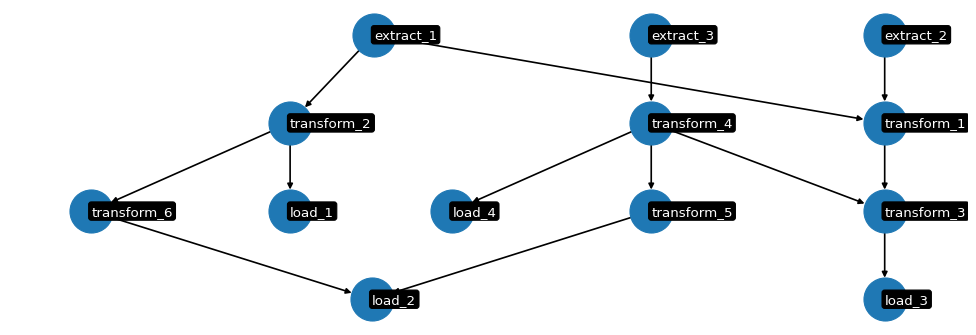

In [150]:
# create a graph object using the dataframe
G = nx.from_pandas_edgelist(schedule_dep, source = "dep_on", target= "process", create_using=nx.DiGraph)

# plot the workflow
pos = graphviz_layout(G, prog="dot")
plt.figure(3 ,figsize=(12, 4), dpi=80)
nx.draw(G,
        pos,
        with_labels = True,
        arrows = True,
        node_size = 1500,
        width = 1.5,
        node_shape = "o",
        font_color = "white",
        font_family = 'calibri bold',
        bbox=dict(facecolor="black", edgecolor='black', boxstyle='round,pad=0.2'),
        horizontalalignment = 'left'
)

plt.show()

In [151]:
# sort the schedule dataframe using graph object
schedule_df['process'] = pd.Categorical(schedule_df['process'], list(nx.topological_sort(G)))
schedule_df = schedule_df.sort_values("process").reset_index(drop=True)
schedule_df

,process,dep_on,location,status,last_run
0,extract_1,NaN,scripts/extract_1.py,no status,never
1,extract_2,NaN,scripts/extract_2.py,no status,never
2,extract_3,NaN,scripts/extract_3.py,no status,never
3,transform_2,extract_1,scripts/transform_2.py,no status,never
4,transform_1,"extract_1,extract_2",scripts/transform_1.py,no status,never
5,transform_4,extract_3,scripts/transform_4.py,no status,never
6,transform_6,transform_2,scripts/transform_6.py,no status,never
7,load_1,transform_2,scripts/load_1.py,no status,never
8,transform_3,"transform_1,transform_4",scripts/transform_3.py,no status,never
9,transform_5,transform_4,scripts/transform_5.py,no status,never


In [152]:
# run the sorted process and catch errors

# empty lists to catch errors
sdtout_list = []
stderr_list = []

for index in range(len(schedule_df)):

    # only run the process if it has no status
    if schedule_df.iloc[index]['status'] == "no status":
        print("running ",schedule_df.iloc[index]['process'])
        result = subprocess.run([ "python", schedule_df.iloc[index]['location']], capture_output=True)
        # append the errors to the empty lists
        sdtout_list.append(result.stdout)
        stderr_list.append(result.stderr)

        # if no errors occur, change the status to success and add the current date
        if result.stderr == b'':
            schedule_df.at[index, 'status'] = 'success'
            schedule_df.at[index, 'last_run'] = datetime.date(datetime.now())

        # if an error occurs, chnage the status to error, and do not run any nodes that depend on this process, change those status to "dependency failed"
        else: 
            schedule_df.at[index, 'status'] = 'error'
            impacted_list = list(nx.dfs_tree(G, source=schedule_df.iloc[index]['process']))
            impacted_list.remove(schedule_df.iloc[index]['process'])
            schedule_df.loc[schedule_df['process'].isin(impacted_list), 'status'] = "dependency failed"
    else:
        pass
   

running  extract_1
running  extract_2
running  extract_3


In [154]:
# create a new graph object
G = nx.from_pandas_edgelist(schedule_dep, source = "dep_on", target= "process", create_using=nx.DiGraph)

# reset the index of schedule dataframe to the same order that processes appear in the graph object
schedule_df = schedule_df.set_index('process')
schedule_df = schedule_df.reindex(G.nodes())

# set the 'status' column to categorical
schedule_df['status']=pd.Categorical(schedule_df['status'])
schedule_df['status'].cat.codes

process
extract_1      1
transform_1    0
extract_2      2
transform_2    0
transform_3    0
transform_4    0
extract_3      1
transform_5    0
transform_6    0
load_1         0
load_2         0
load_3         0
load_4         0
dtype: int8

In [155]:
# colour mapping based on status for visualisation
colour_map = []

for index, row in schedule_df.iterrows():
    if row['status'] == 'no status':
        colour_map.append("grey")
    elif row['status'] == 'success':
        colour_map.append("tab:green")
    elif row['status'] == 'error':
        colour_map.append("tab:red")
    elif row['status'] == 'dependency failed':
        colour_map.append("tab:blue")
    else:
        colour_map.append("pink")

colour_map

['tab:red',
 'tab:blue',
 'tab:green',
 'tab:blue',
 'tab:blue',
 'tab:blue',
 'tab:red',
 'tab:blue',
 'tab:blue',
 'tab:blue',
 'tab:blue',
 'tab:blue',
 'tab:blue']

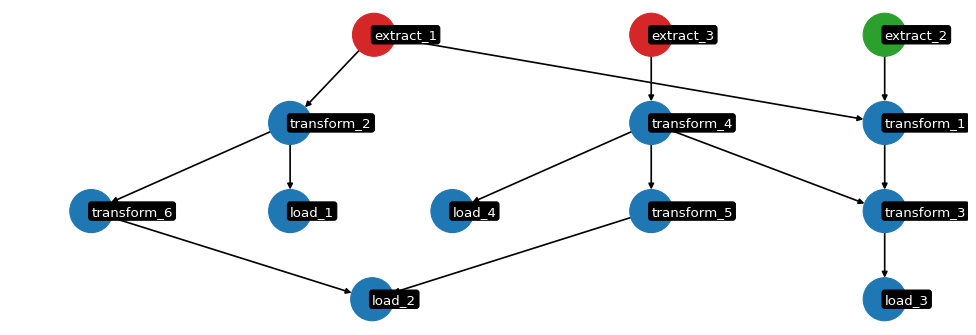

In [156]:
# plot the new graph to visualise the status of the schedule
pos = graphviz_layout(G, prog="dot")
plt.figure(3 ,figsize=(12, 4), dpi=80)
nx.draw(G,
        pos,
        with_labels = True,
        arrows = True,
        node_size = 1500,
        width = 1.5,
        node_color = colour_map,
        node_shape = "o",
        font_color = "white",
        font_family = 'calibri bold',
        bbox=dict(facecolor="black", edgecolor='black', boxstyle='round,pad=0.2'),
        horizontalalignment = 'left'
)


plt.show()